<a href="https://colab.research.google.com/github/geo-tp/053-Database-Frontend/blob/master/vgg16_custom_dogs_cats_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customize VGG16 to match a specific use

- VGG16 is an image categories classifier trained over 1.4m samples from 1000 categories.

- We will use its base pre-trained model and add custom layers

- We will add data augmentation on training dataset to prevent overfitting

- We will train it with dogs and cats pictures

- We must freeze the base model to not destroy past training

- We could fine tune top VGG16 convnets layers to increase accuracy

- This method should run on a GPU, it needs a lot of computer calculation

The customized pre-trained model should be able to predict if an image shows a dog or a cat.

In [1]:
# DATASET & PREPROCESSING - 4000 images of cats and dogs
# Splitted into 2000 for trainset, 1000 for validation set and 1000 for test set

import os
from sys import path
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
 

# Path where dataset should stand
base_dir = path[0] + "/drive/MyDrive/dog-cat-dataset/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Use data augmentation to create 4 variations for each image
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Final generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [2]:
# MODEL DEFINITION - VGG16 convnets with custom top layers
# This model should predict if an image shows a dog or a cat

from keras.applications import VGG16
from keras import models
from keras import layers

# We use imagenet weights
# We keep only the convnets part
# Top denses layers are not included
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc']
)

     

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [3]:
# FREEZE - trainable ability of VGG16 is disabled
# If not, training a new dataset will destroy past weight adjustments

conv_base.trainable = False

In [ ]:
# TRAINING - Use a GPU

history = model.fit(
  train_generator,
  steps_per_epoch=100,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=50
)

In [ ]:
# LOG TRAINING RESULTS

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


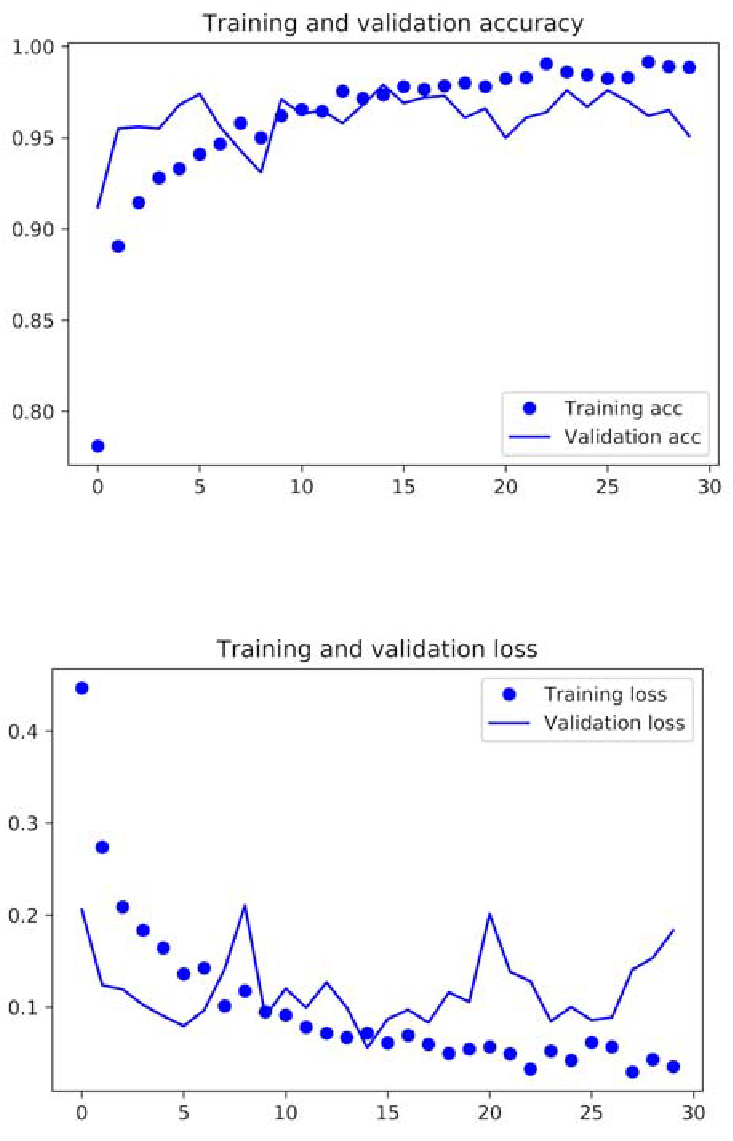

In [ ]:
# EVALUATION - We could expect 95% acurracy

score = model.evaluate(test_generator)
print(model.metrics_names)
print(score)

In [5]:
# FINE TUNE - Train top layers of VGG16 convnets

conv_base.summary()

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1': # from here, convnets will be trainable
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# FINE TUNE TRAINING - Train VGG16 top convnets using a very low learning rate 

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc']
)

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

In [ ]:
# EVALUATION - We could expect 97% acurracy after fine tuning

score = model.evaluate(test_generator)
print(model.metrics_names)
print(score)